In [1]:
import h5py
import numpy as np

from keras.layers import Input, Dense, Activation, MaxPooling2D, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Dropout
from keras.models import Model

from keras.utils import plot_model
from keras.metrics import MeanSquaredError, CategoricalAccuracy

from keras.initializers import glorot_uniform

import keras.backend as K
K.set_image_data_format('channels_last')

Using TensorFlow backend.


First, let's load the training and test data set that we created earlier.

In [5]:
def get_data(filepath):
    data_file = h5py.File(filepath,'r')

    train_data = data_file['train_data'][:]
    train_labels = data_file['train_labels'][:]

    test_data = data_file['test_data'][:]
    test_labels = data_file['test_labels'][:]

    return train_data, train_labels, test_data, test_labels

data_save_path = '../../img/label_data'
data_set_name='coffee_label_data.h5'
filepath=os.path.join(data_save_path,data_set_name)
train_data, train_labels, test_data, test_labels  = get_data(filepath)
print('Training Data Shape:',train_data.shape)
print('Test Data Shape:',test_data.shape)

Training Data Shape: (1067, 540, 960, 3)
Test Data Shape: (267, 540, 960, 3)


Now, let's define our model. Using keras, we define the first layer of the model based on the image dimensions, which would be (width, height, channels). After this, we add a series of 2D convolutional layers which consists of a covolution operation, a non-linear activation, and then a max pooling layer. Hyperparameters for the number of filters, filter size, etc. are defined in a list for each layer. The convolutional layers act as spatial feature detectors which learn different feature representations which will be used by the next steps.

Then, the output is flattened, and we add a number of dense fully connected layers that are also defined as a list. Each layer consists of the numbber of hidden units,  

Finally, we add the output layer. If we are using this as a multi-class problem (e.g. varying amounts of coffee pot fullness are bucketed and each is treated as a separate class), then our final output layers consists of a neuron for each class, with softmax activation. Otherwise, in the regression case (where we treat the output as a continuous variable), we add a dense layer with a single node which would output values betwen the range of 0-1. Mean squared error is then used as the loss function to train the network. 

In [2]:
def iShameModel(input_shape, conv_layers, conn_layers, output_classes=None):

    # input layer
    X_input = Input(input_shape)
    X = X_input

    # convlutional layers
    # CONV2D -> RELU -> MAXPOOL
    # number of filters, filter_size, and strides retrieved from input conv array

    for idx, layer in enumerate(conv_layers):        
        X = Conv2D(layer["num_filters"], layer["filter_size"], strides = layer["filter_size"], \
                    name = 'conv_'+str(idx), kernel_initializer = glorot_uniform(seed=0))(X)
        #X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
        X = Activation(layer["activation"])(X)
        X = MaxPooling2D(layer["filter_size"], strides=layer["stride_size"], name="max_pool_"+str(idx))(X)

    # add fully connected layers
    X = Flatten()(X)

    for idx, layer in enumerate(conn_layers):
        X = Dense(layer["hidden_units"], activation=layer["activation"], name="fully_connected_"+str(idx))(X)
        if "dropout" in layer:
            X = Dropout(layer["dropout"])(X)

    # if classification, add softmax output layer
    # otherwise, add singular output layer with one unit with NO activation
    if output_classes is not None:
        X = Dense(output_classes, activation='softmax', name='class_output_'+str(output_classes), kernel_initializer = glorot_uniform(seed=0))(X)
    else:
        X = Dense(1, name = 'regression_output')(X)

    model = Model(inputs=X_input, outputs=X, name='iShame')

    return model

Next, define the layers for our CNN, as explained above.

In [3]:
conv_layers = [{"num_filters": 16,
                "filter_size": (3,3),
                "stride_size": (1,1),
                "activation": "relu",
                "pool_size": (2,2)
                },
                {"num_filters": 32,
                "filter_size": (3,3),
                "stride_size": (1,1),
                "activation": "relu",
                "pool_size": (2,2)
                },
                {"num_filters": 64,
                "filter_size": (3,3),
                "stride_size": (1,1),
                "activation": "relu",
                "pool_size": (2,2)
                }]
conn_layers = [{"hidden_units": 500,
                "activation": "relu",
                "dropout": 0.5
                },
                {"hidden_units": 100,
                "activation": "relu"
                },
                {"hidden_units": 20,
                    "activation": "relu"
                }]

Now let's define some additional hyperparameters for our model, based on whether we are treating this as a classification or regression problem.

In [6]:
regression_output = False
if(regression_output):
    num_classes=None
    loss="mean_squared_error"
    metrics=[MeanSquaredError()]
else:
    num_classes=train_labels.shape[-1]
    loss="categorical_crossentropy"
    metrics=[CategoricalAccuracy()]
batch_size=32
epochs=10

We're now ready to build our model.

In [7]:
model = iShameModel(input_shape=train_data.shape[1:],conv_layers=conv_layers,conn_layers=conn_layers,output_classes=num_classes)
model.compile(optimizer='adam', loss=loss, metrics=metrics)


Let's take a look at the different layers. We can the convolutional and fully connected layers defined in the config have been successfully created. 

In [8]:
model.summary()

Model: "iShame"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 540, 960, 3)       0         
_________________________________________________________________
conv_0 (Conv2D)              (None, 180, 320, 16)      448       
_________________________________________________________________
activation_1 (Activation)    (None, 180, 320, 16)      0         
_________________________________________________________________
max_pool_0 (MaxPooling2D)    (None, 178, 318, 16)      0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 59, 106, 32)       4640      
_________________________________________________________________
activation_2 (Activation)    (None, 59, 106, 32)       0         
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 57, 104, 32)       0    

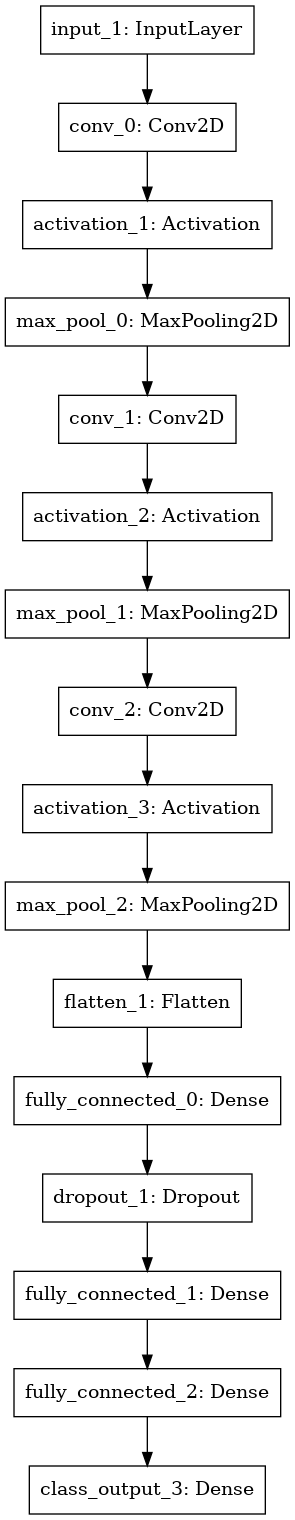

In [9]:
plot_model(model)

Now, we train our model with the given training data and hyperparameters.

In [21]:
model.fit(train_data, train_labels, epochs = epochs, batch_size = batch_size)

Epoch 1/10
1067/1067 [==============================] - 259s 242ms/step - loss: 0.7531 - categorical_accuracy: 0.6701
Epoch 2/10
1067/1067 [==============================] - 249s 233ms/step - loss: 0.0210 - categorical_accuracy: 0.9934
Epoch 3/10
1067/1067 [==============================] - 240s 225ms/step - loss: 0.0012 - categorical_accuracy: 1.0000
Epoch 4/10
1067/1067 [==============================] - 239s 224ms/step - loss: 0.0118 - categorical_accuracy: 0.9944
Epoch 5/10
1067/1067 [==============================] - 237s 222ms/step - loss: 0.0122 - categorical_accuracy: 0.9953
Epoch 6/10
1067/1067 [==============================] - 235s 221ms/step - loss: 0.0030 - categorical_accuracy: 0.9991
Epoch 7/10
1067/1067 [==============================] - 231s 217ms/step - loss: 1.5548e-04 - categorical_accuracy: 1.0000
Epoch 8/10
1067/1067 [==============================] - 236s 221ms/step - loss: 3.1412e-04 - categorical_accuracy: 1.0000
Epoch 9/10
1067/1067 [==========================

Let's verify our model performance by checking our performance on our holdout set.

In [22]:
results = model.evaluate(test_data, test_labels)
print("Loss:",results[0])
print("Metric:",results[1])

267/267 [==============================] - 33s 123ms/step
Loss: 2.732399707809386e-07
Metric: 1.0
